# Agents

In [1]:
# pip install langchain langchain-core langchain-community langchain-experimental langchain-openai openai langgraph

In [2]:
import os
from dotenv import load_dotenv

print(os.getcwd())
load_dotenv('.env')

c:\Users\40100275\OneDrive - Anheuser-Busch InBev\7 may 2020\2021 Explore\OpenAI\3ai_presentation\GNEAI _LEARNING_MONTH\Langchain


True

The core idea of `agents` is to use a language model to choose a sequence of `actions` to take. In chains, a `sequence of actions` is hardcoded (in code). In agents, a language model is used as a reasoning engine to determine which actions to take and in which order.

# AGENT = Prompt + LLM + TOOLS

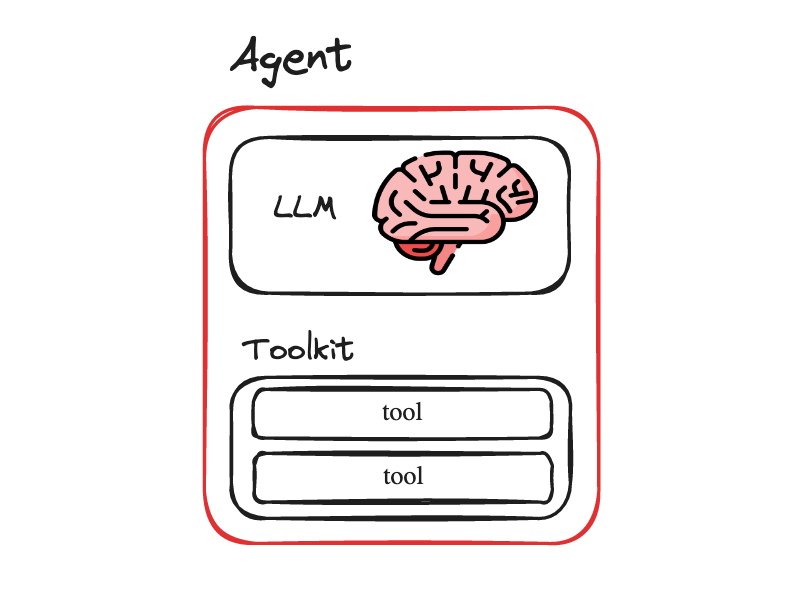


### AgentExecutor
The agent executor is the runtime for an agent. This is what actually calls the agent, executes the actions it chooses, passes the action outputs back to the agent, and repeats. In pseudocode, this looks roughly like:

```python
next_action = agent.get_action(...)
while next_action != AgentFinish:
    observation = run(next_action)
    next_action = agent.get_action(..., next_action, observation)
return next_action

```

_________________________________________________________________________________________________________________________________________________________________________
##### Agent Action
This is a dataclass that represents the action an agent should take. It has a tool property (which is the name of the tool that should be invoked) and a tool_input property (the input to that tool)


##### Agent Finish
This represents the final result from an agent, when it is ready to return to the user. It contains a return_values key-value mapping, which contains the final agent output. Usually, this contains an output key containing a string that is the agent's response.


##### Intermediate Steps
These represent previous agent actions and corresponding outputs from this CURRENT agent run. These are important to pass to future iteration so the agent knows what work it has already done. This is typed as a `List[Tuple[AgentAction, Any]]`. Note that observation is currently left as type Any to be maximally flexible. In practice, this is often a string.

_________________________________________________________________________________________________________________________________________________________________________




### Tools

1. Tools are functions that an agent can invoke. The Tool abstraction consists of two components:

    The input schema for the tool. This tells the LLM what parameters are needed to call the tool.

    Without this, it will not know what the correct inputs are.

    These parameters should be sensibly named and described

2. The function to run. This is generally just a Python function that is invoked.

### Agent Types


- Supports Chat History

- Supports Multi-Input Tools

- Supports Parallel Function Calling

https://python.langchain.com/v0.1/docs/modules/agents/agent_types/

- **CHAT_CONVERSATIONAL_REACT_DESCRIPTION**: An agent designed for engaging in conversational interactions with reactive responses based on context.

- **CHAT_ZERO_SHOT_REACT_DESCRIPTION**: An agent that generates reactive responses in conversations without needing prior examples or context.

- **CONVERSATIONAL_REACT_DESCRIPTION**: A reactive agent focused on providing responses in an ongoing conversation, adapting to the evolving context.

- **OPENAI_FUNCTIONS**: An agent that leverages specific functions or tools to generate responses or perform tasks as instructed.

- **OPENAI_MULTI_FUNCTIONS**: An agent capable of utilizing multiple functions or tools simultaneously to respond or complete complex tasks.

- **REACT_DOCSTORE**: An agent that retrieves and reacts to information stored in documents or a database.

- **SELF_ASK_WITH_SEARCH**: An agent that asks clarifying questions and uses search functionality to refine and provide accurate responses.

- **STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION**: A structured, zero-shot agent that reacts and responds in conversations without needing prior context.

- **ZERO_SHOT_REACT_DESCRIPTION**: A general agent that provides reactive responses without needing any prior training or examples.


### ReAct Agent prompt

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer

Thought: you should always think about what to do

Action: the action to take, should be one of [{tool_names}]

Action Input: the input to the action

Observation: the result of the action

... (this Thought/Action/Action Input/Observation can repeat N times)

Thought: I now know the final answer

Final Answer: the final answer to the original input question

Begin!

Question: {input}

Thought:{agent_scratchpad}

### LLM Model

In [3]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

def get_llm(
    azure_deployment="gpt-4",
    api_version="2024-06-01",
    temperature=0,
    timeout=600,
    max_tokens=4096,
    max_retries=1,
):
    return AzureChatOpenAI(
        azure_deployment=azure_deployment,
        api_version=api_version,
        temperature=temperature,
        timeout=timeout,
        max_tokens=max_tokens,
        max_retries=max_retries,
    )

llm = get_llm()

## What is a Tool?

A tool is a function wrapped in an Tool object with a defined input and output schema and has a meaningful name and description

In [12]:
# Internet Search tool

from langchain_community.tools.tavily_search import TavilySearchResults

# Instantiate the TavilySearch tool
tavily_search_tool = TavilySearchResults(max_results=3)

print(tavily_search_tool.name, " ::: ", tavily_search_tool.description)

tavily_search_tool.invoke("What are the current sponsorships that AbInBev has with the NFL?")

tavily_search_results_json  :::  A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.


[{'url': 'https://www.sportsbusinessjournal.com/Daily/Issues/2021/12/20/Marketing-and-Sponsorship/AB-NFL.aspx',
  'content': "Anheuser-Busch InBev has renewed its longstanding league sponsorship with the NFL. The five-year extension continues an agreement that began in '10, when A-BI replaced Coors. The brewer's current agreement was due to expire in March '22. Bud Light will continue as the lead brand for NFL activation."},
 {'url': 'https://www.anheuser-busch.com/newsroom/anheuser-busch-and-the-national-football-league-extend-partnership',
  'content': "In addition to the brewer's exclusive sponsorship with the NFL, Anheuser-Busch also has 27 NFL team partnerships and endorsement deals with more than 25 current players. ABOUT ANHEUSER-BUSCH For more than 160 years, Anheuser-Busch has carried on a legacy of brewing great-tasting, high-quality beers that have satisfied beer drinkers for generations."},
 {'url': 'https://www.sportcal.com/sponsorship/ab-inbev-returns-as-partner-of-nfls-c

In [5]:
# Add tools to the tools list

tools = [tavily_search_tool]

In [6]:
# Agent prompt
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Make sure to use only tavily_search_results_json for information to answer user question.\
            Use Tavily Search tool to search the internet for information. Provide a search query as input.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

In [7]:
# Construct the Tools agent
from langchain.agents import AgentExecutor, create_openai_tools_agent

agent = create_openai_tools_agent(llm, tools, prompt)

References : https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/agents/openai_tools/base.py

In [8]:
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors = True)

In [9]:
agent_executor.invoke({"input": "what is a LangChain agent?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'LangChain agent'}`


[{'url': 'https://python.langchain.com/v0.1/docs/modules/agents/', 'content': 'Learn how to use LangChain agents and chains to build cognitive applications with LLMs and other components. Agents are reusable units of intelligence that can perform tasks, while chains are sequences of agents that achieve goals.'}]A LangChain agent is a reusable unit of intelligence that can perform tasks. It is used in conjunction with LangChain chains to build cognitive applications with Large Language Models (LLMs) and other components. Chains are sequences of agents that work together to achieve specific goals. You can learn more about how to use LangChain agents and chains from the [official documentation](https://python.langchain.com/v0.1/docs/modules/agents/).

> Finished chain.


{'input': 'what is a LangChain agent?',
 'output': 'A LangChain agent is a reusable unit of intelligence that can perform tasks. It is used in conjunction with LangChain chains to build cognitive applications with Large Language Models (LLMs) and other components. Chains are sequences of agents that work together to achieve specific goals. You can learn more about how to use LangChain agents and chains from the [official documentation](https://python.langchain.com/v0.1/docs/modules/agents/).'}

In [10]:
out = agent_executor.invoke({"input": "What is the capital of France and what is its population?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'capital of France'}`


[{'url': 'https://www.britannica.com/facts/Paris', 'content': 'Learn about Paris, the capital of France, and its history, culture, landmarks, and people. Find out why Paris is called "the City of Light" and when it was founded, liberated, and attacked.'}]
Invoking: `tavily_search_results_json` with `{'query': 'population of Paris France'}`


[{'url': 'https://worldpopulationreview.com/cities/france/paris', 'content': "Paris, France Population 2024 Paris's 2024 population is now estimated at 11,276,701. In 1950, the population of Paris was 6,283,018. Paris has grown by 68,261 in the last year, which represents a 0.61% annual change.These population estimates and projections come from the latest revision of the UN World Urbanization Prospects. These estimates represent the Urban agglomeration of Paris, which ..."}]The capital of France is Paris. As of 2024, the estimate

In [11]:
print(out['output'])

The capital of France is Paris. As of 2024, the estimated population of Paris is 11,276,701.


In [13]:
agent_executor.invoke({"input": "Hi I am Subhajit"})



> Entering new AgentExecutor chain...
Hello, Subhajit! How can I assist you today?

> Finished chain.


{'input': 'Hi I am Subhajit',
 'output': 'Hello, Subhajit! How can I assist you today?'}